In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [2]:
test = pd.read_csv('./data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('./data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('./data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('./data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('./data/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

## Join data sets

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

## Let's take a look at the raw data

In [4]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.tail())
display(train.describe())

Train rows: 2935849
Train columns: 10


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
2935844,2015-10-10,33,25,7409,299.00,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-09-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.00,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.00,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3
2935848,2015-03-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


## Time period of the dataset

In [5]:
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


I'm leaving only the "shop_id" and "item_id" that exist in the test set to have more accurate results.

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int32
 1   shop_id  214200 non-null  int32
 2   item_id  214200 non-null  int32
dtypes: int32(3)
memory usage: 2.5 MB


In [8]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

## Data preprocessing

- I'm dropping all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
- We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
- Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [9]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224439 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1224439 non-null  datetime64[ns]
 1   date_block_num      1224439 non-null  int32         
 2   shop_id             1224439 non-null  int32         
 3   item_id             1224439 non-null  int32         
 4   item_price          1224439 non-null  float32       
 5   item_cnt_day        1224439 non-null  int32         
 6   item_name           1224439 non-null  object        
 7   item_category_id    1224439 non-null  int32         
 8   shop_name           1224439 non-null  object        
 9   item_category_name  1224439 non-null  object        
dtypes: datetime64[ns](1), float32(1), int32(5), object(3)
memory usage: 74.7+ MB


None

In [10]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10))
display(train_monthly.describe())

,date_block_num,shop_id,item_id,item_cnt,item_cnt_month
0,0,2,33,1,2.00
1,0,2,482,1,1.00
2,0,2,491,1,1.00
3,0,2,839,1,1.00
4,0,2,1007,3,1.00
5,0,2,1010,1,1.00
6,0,2,1023,2,1.00
7,0,2,1204,1,NaN
8,0,2,1224,1,NaN
9,0,2,1247,1,NaN


,date_block_num,shop_id,item_id,item_cnt,item_cnt_month
count,593829.00,593829.00,593829.00,593829.00,482536.00
mean,20.18,32.07,10015.02,2.10,2.07
std,9.14,16.90,6181.82,2.31,2.17
min,0.00,2.00,30.00,0.00,0.00
25%,13.00,19.00,4418.00,1.00,1.00
50%,22.00,31.00,9171.00,1.00,1.00
75%,28.00,47.00,15334.00,2.00,2.00
max,33.00,59.00,22167.00,20.00,20.00


## Time-series processing

- As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
- This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan").

In [11]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair

In [12]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


## Dropping identifier columns as we don't need them anymore

In [13]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

## Train and validation sets

In [14]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [15]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


## Reshape data.

- Time-series shape (data points, time-steps, features).

In [16]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


##### First let's begin with how a regular RNN time-series approach could be.

## Regular LSTM model.

In [17]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.GRU(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.GRU(6, activation='relu', return_sequences=True))
lstm_model.add(L.GRU(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 10)            390       
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 6)             324       
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 27        
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 882
Trainable params: 882
Non-trainable params: 0
__________________________________________________________

In [18]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 71s - loss: 1.4633 - val_loss: 1.2532
Epoch 2/20
1566/1566 - 58s - loss: 1.2465 - val_loss: 1.1924
Epoch 3/20
1566/1566 - 58s - loss: 1.2099 - val_loss: 1.1800
Epoch 4/20
1566/1566 - 56s - loss: 1.1969 - val_loss: 1.1713
Epoch 5/20
1566/1566 - 54s - loss: 1.1886 - val_loss: 1.1695
Epoch 6/20
1566/1566 - 54s - loss: 1.1829 - val_loss: 1.1633
Epoch 7/20
1566/1566 - 54s - loss: 1.1785 - val_loss: 1.1600
Epoch 8/20
1566/1566 - 54s - loss: 1.1749 - val_loss: 1.1588
Epoch 9/20
1566/1566 - 54s - loss: 1.1725 - val_loss: 1.1542
Epoch 10/20
1566/1566 - 53s - loss: 1.1705 - val_loss: 1.1519
Epoch 11/20
1566/1566 - 54s - loss: 1.1687 - val_loss: 1.1527
Epoch 12/20
1566/1566 - 54s - loss: 1.1674 - val_loss: 1.1511
Epoch 13/20
1566/1566 - 54s - loss: 1.1662 - val_loss: 1.1481
Epoch 14/20
1566/1566 - 54s - loss: 1.1649 - val_loss: 1.1476
Epoch 15/20
1566/1566 - 54s - loss: 1.1638 - val_loss: 1.1510
Epoch 16/20
1566/1566 - 54s - loss: 1.1631 - val_loss: 1.1468
Epoch 17/20
1566/

###### Model training

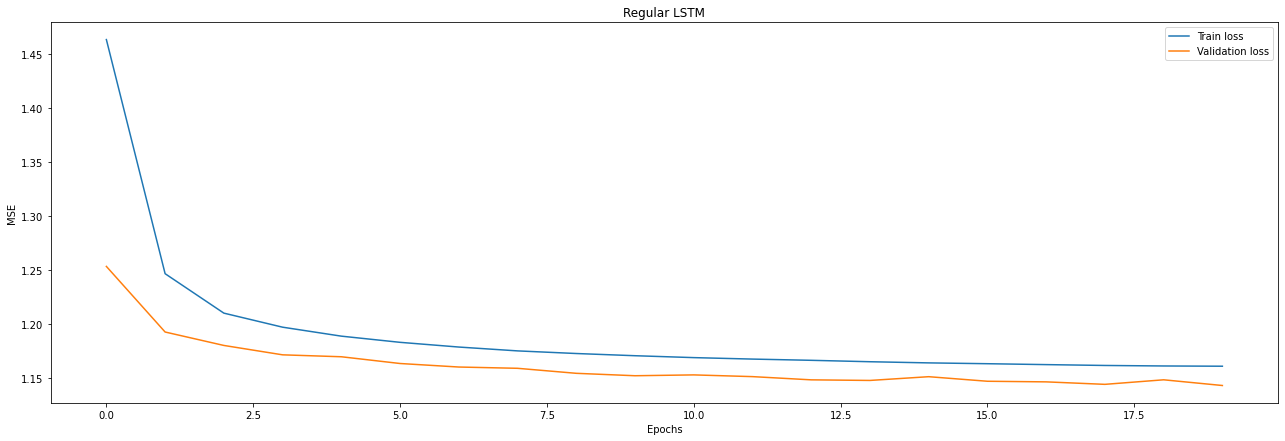

In [19]:
fig, ax1 = plt.subplots(1, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.show()

##### Regular LSTM on train and validation

In [20]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 1.0768328224725527
Validation rmse: 1.0690580284750093


##### Build test set
Since we have two models I'll build test sets to apply on both of them.

In [21]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Regular LSTM model test predictions
- For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [22]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Reshape data.
- Time-series shape (data points, time-steps, features).

In [23]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


##### Making predictions.

In [24]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

##### Predictions from the regular LSTM model.

In [25]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
# lstm_prediction.to_csv('gru_submission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.52
1,1,0.49
2,2,0.76
3,3,0.25
4,4,0.49
5,5,0.37
6,6,0.95
7,7,0.13
8,8,1.44
9,9,0.49
